In [2]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

In [3]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv")
meta

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [4]:
meta["Glaucoma"].value_counts()

Glaucoma
0    482
1    168
Name: count, dtype: int64

In [5]:
all_images = glob("/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/*.jpg")
root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(root, fn))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Path
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...


In [6]:
meta.groupby("Glaucoma")["ExpCDR"].mean()

Glaucoma
0    0.542243
1    0.674040
Name: ExpCDR, dtype: float64

### Visualize Fondus Images

(3072, 2048)


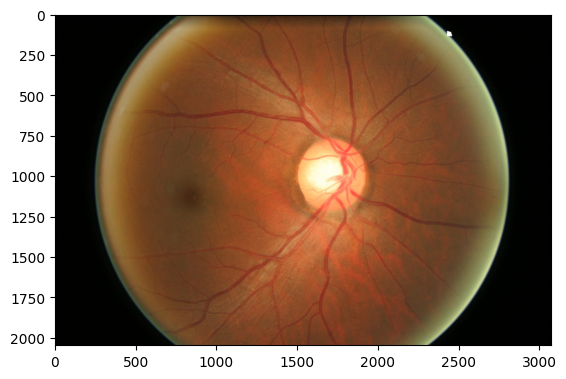

In [7]:
image = Image.open(all_images[0])
print(image.size)
plt.imshow(image)

In [9]:
def gamma_correct(img, gamma=0.4):
    img = img.astype(np.uint8)
    lookUpTable = np.empty((1,256), np.uint8)

    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    out = cv2.LUT(img, lookUpTable)
    return out

def clahe(image, cl=2.0, tgs=8):
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(tgs, tgs))
    cl1 = clahe.apply(image)
    return cl1

def clahe_rgb(img, cl=2.0, tgs=8):
    g, b, r = cv2.split(img)
    g, b, r = clahe(g), clahe(b), clahe(r)
    return cv2.merge([g, b, r])

def apply_gaussian(img):
    img = cv2.GaussianBlur(img, (5,5), 0)
    return img 

def get_bounding_box(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return [x, y, w, h]

def remove_black_padding(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # finding the biggest box and it's corresponding bboxes
    x, y, w, h = get_bounding_box(th)
    
    c_size = 300
    final_size = 224
    
    images = []

    for i, image in enumerate([clahe(gray), gamma_correct(gray, 3), clahe_rgb(img), img]):
        
        # removing empty padding and noninformative parts
        crop = image[y+c_size:y+h-c_size, x+c_size:x+w-c_size]
        
        # resizing to the final size
        crop_resized = cv2.resize(crop, (final_size, final_size))
        
        if i == 2:
            images.append(crop)
            
        images.append(crop_resized)
        
    return images

def crop_cup_disc(img, mask):
    x, y, w, h = get_bounding_box(mask)
    width_ratio = img.shape[1]/mask.shape[1]
    height_ratio = img.shape[0]/mask.shape[0]
    x, w = int(x * width_ratio), int(w * width_ratio)
    y, h = int(y * height_ratio), int(h * height_ratio)
    
    # Estimated center of the disc
    cx = x + w//2
    cy = y + h//2
    
    # Cropping a 500 * 500 image that contains the disc
    c_size = 300
    x_start = (cx-c_size) if (cx > c_size) else 0
    y_start = (cy-c_size) if (cy > c_size) else 0
    crop = img[y_start:cy+c_size, x_start:cx+c_size]
    
    # Resizing to the final size
    final_size = 224
    crop = cv2.resize(crop, (final_size, final_size))

    return crop

In [10]:
def ensure_cluster_groups(data_2d, labels, clusters=4):
    # ensuring the clusters order
    mean_intensities = [data_2d[labels == i].mean() for i in range(clusters)]
    label_map = {i: label for i, label in sorted(enumerate(mean_intensities), key=lambda x: x[1])}
    label_map = {k: i for i, k in enumerate(label_map.keys())}
    mapped_labels = np.vectorize(label_map.get)(labels)
    return mapped_labels

def cluster_image(img):
    slc_image = img

    # clustering
    data_2d = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=6, n_init=3, random_state=0).fit(data_2d)

    # Reshape the labels back to original shape
    labels = kmeans.labels_
    labels = ensure_cluster_groups(data_2d, labels, 6)
    labels = labels.reshape(img.shape)

    # Create a binary mask by thresholding the brain intensity
    mask = np.isin(labels, [4, 5])
    mask = (mask * 255).astype(np.uint8)

    return mask

In [11]:
def apply_morphology(binary_mask):
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    final = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)
    
    return final

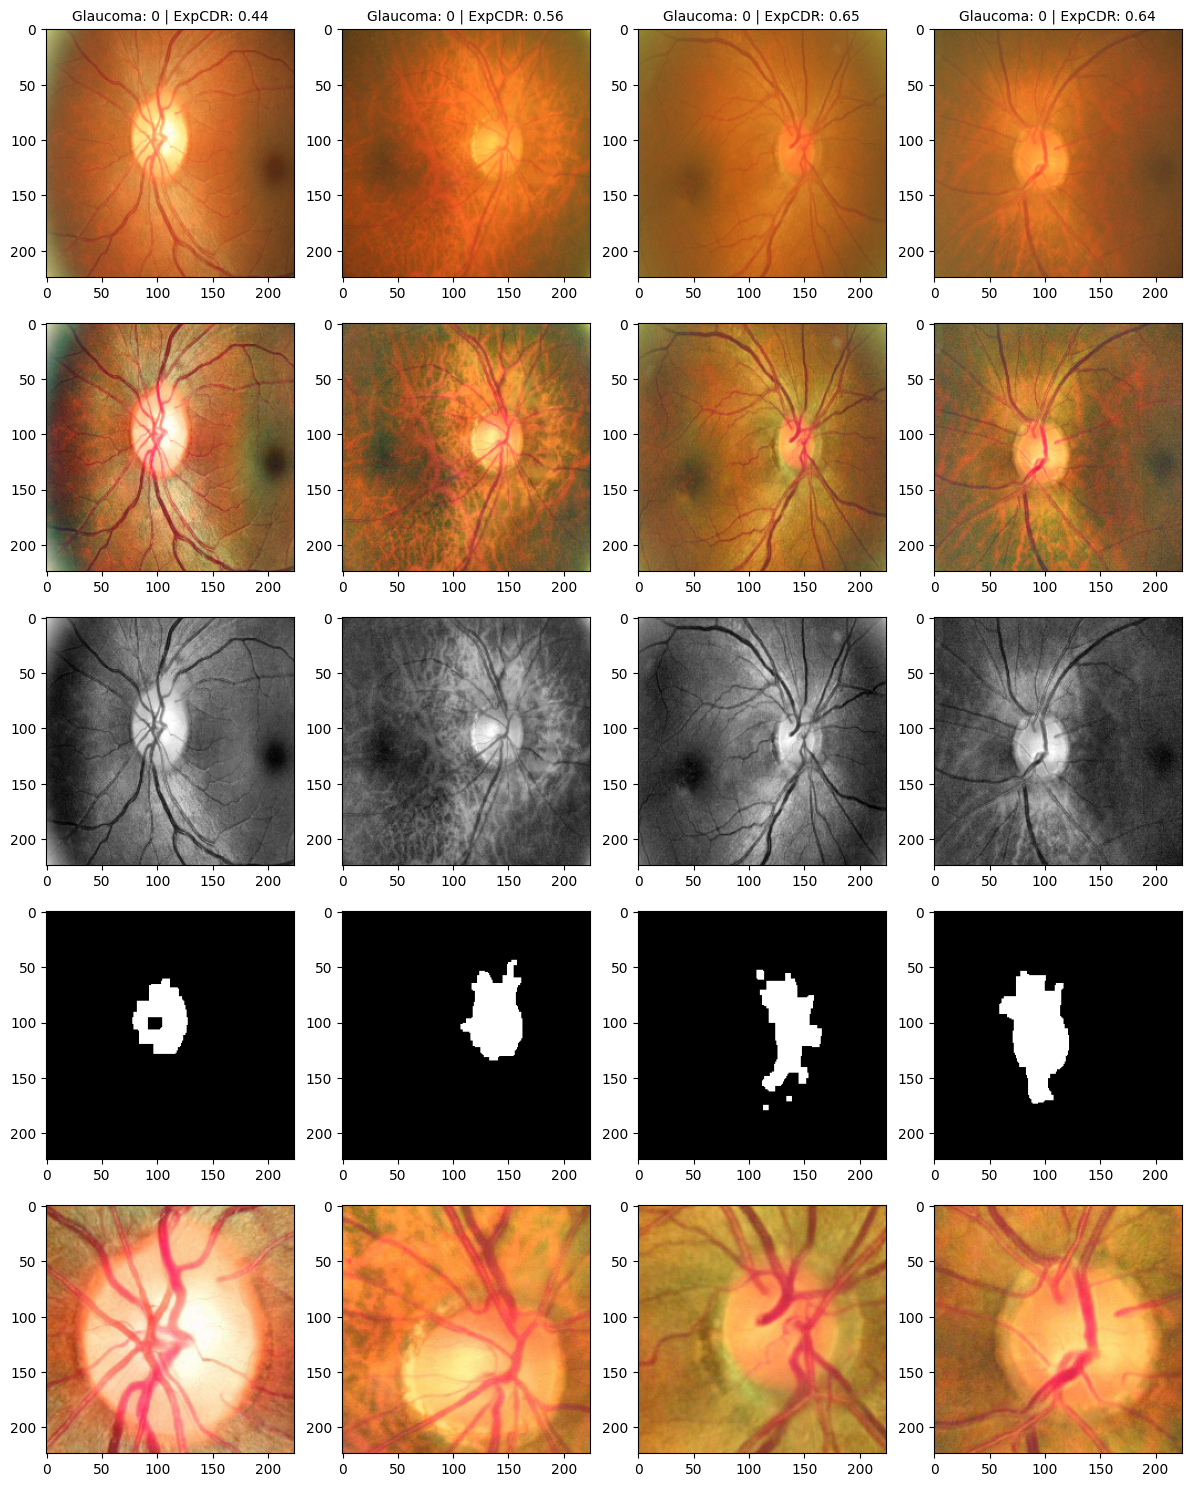

In [12]:
fig, axs = plt.subplots(5, 4, figsize=(12, 15))

for i in range(4):
    path = all_images[160 + i]
    
    # Finding Glaucoma Dx and ExpCDR
    file_name = Path(path).parts[-1]
    row = meta.loc[meta["Filename"] == file_name].iloc[0]
    gl, exp_cdr = row["Glaucoma"], row["ExpCDR"]
    
    img = cv2.imread(path)
    clahe_gray, corrected_gray, rgb_clahe_org, rgb_clahe_cropped, rgb_cropped = remove_black_padding(img, 10)
    
    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)
    
    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)
    
    axs[0, i].imshow(rgb_cropped[..., ::-1])
    axs[0, i].set_title(f"Glaucoma: {gl} | ExpCDR: {exp_cdr:0.2f}", fontsize=10)
    axs[1, i].imshow(rgb_clahe_cropped[..., ::-1])
    axs[2, i].imshow(clahe_gray, cmap='gray')
    axs[3, i].imshow(segmented, cmap='gray')
    axs[4, i].imshow(rgb_cup[..., ::-1])
    
plt.tight_layout()
plt.show()

### Save cropped images

In [13]:
from tqdm import tqdm
import os

save_path = "/kaggle/working/cropped_images"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
for image_path in tqdm(all_images):
    image_name = Path(image_path).parts[-1]
    
    new_path = os.path.join(save_path, image_name)
    
    img = cv2.imread(image_path)
    _, corrected_gray, rgb_clahe_org, _, _ = remove_black_padding(img, 10)
    
    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)
    
    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)
    
    cv2.imwrite(new_path, rgb_cup)

100%|██████████| 650/650 [05:07<00:00,  2.11it/s]


In [15]:
save_path = "/kaggle/working/cropped_images"
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()

In [16]:
print(len(new_meta))

338


# Preparing data for model training and testing

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)

(253, 6) (85, 6)


In [18]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image

class GlaucomaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.data = self.get_data()
    
    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            name = Path(row["Path"]).parts[-1]
            path = os.path.join(save_path, name)
            data.append(((path, exp_cdr), label))
        return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the transformations for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
train_data = GlaucomaDataset(train_df, train_transforms)
test_data = GlaucomaDataset(test_df, test_transforms)
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

In [23]:
one_batch = next(iter(train_loader))

### Visualize a batch

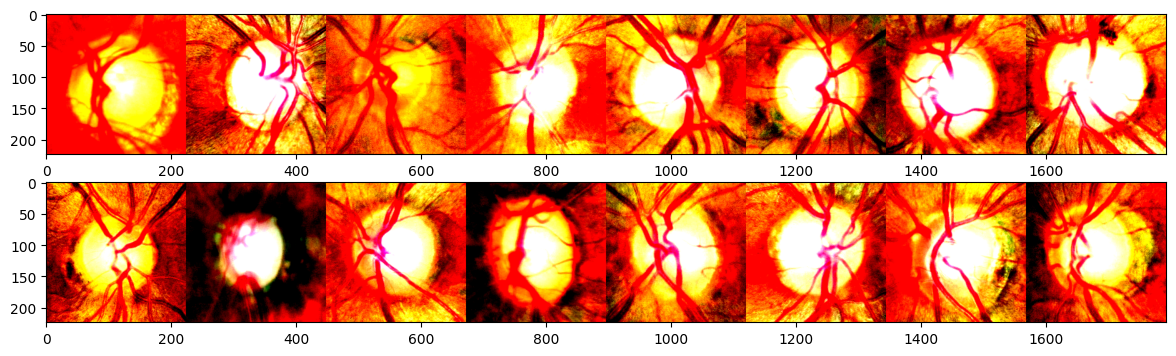

In [24]:
batch_imgs = one_batch[0][0].numpy()
rows = 2
fig, axs = plt.subplots(rows, 1, figsize=(16, 4))
for i in range(rows):
    img = np.hstack([batch_imgs[j].transpose(1, 2, 0) for j in range(i * (b_size//rows), (b_size//rows) * (i+1))])
    axs[i].imshow(img)
plt.show()

# Model

In [30]:
import torch
from torch import nn
from torchvision import models
import torchvision.models as models

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()

        # 加载 ResNet-50，并指定 weights 参数
        # models.ResNet50_Weights.IMAGENET1K_V1 表示加载 ImageNet 上的预训练权重
        self.cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # 然后像之前解释的那样，进行参数冻结和分类层替换：
        for param in self.cnn_model.parameters():
            param.requires_grad = False
            
        # 替换最后一层 fc，使其输出 30 个特征
        num_features = self.cnn_model.fc.in_features
        self.cnn_model.fc = nn.Linear(num_features, 30)
        # 注意：新创建的 nn.Linear 层的参数默认是 requires_grad=True，因此它不会被冻结，可以正常训练。
        
        # Feed-forward network for numerical data
        self.ff_model = nn.Sequential(
            nn.Linear(1, 16),  # Assume numerical input has 1 feature
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        
        #self.ff_model.to("cuda:0")
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Assume binary classification
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x2 = self.ff_model(exp_cdr)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layers(x)
        return x

In [32]:
model = CombinedModel()
#model = model.to("cuda:0")

In [33]:
from fastai.vision.all import *
from fastai.vision import *

from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

learner = Learner(DataLoaders(train_loader, test_loader), model,
                  metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                  loss_func=CrossEntropyLossFlat())

In [34]:
# 定义保存模型的回调函数
save_best = SaveModelCallback(
    monitor='f1_score',  # 监控 F1 Score（或者您最关心的指标，如 valid_loss 或 RocAucBinary）
    fname='best_glaucoma_model' # 模型文件的名称，将保存在 learner.path/models/ 目录下
)

early_stop = EarlyStoppingCallback(
    monitor='f1_score', # 监控的指标
    min_delta=0.01,       # 最小变化量，如果指标的变化小于此值，则认为没有改进
    patience=10          # 容忍度/耐心值，允许模型在没有改进的情况下运行的 epoch 数
)

# --- 使用早停进行训练 ---
learner.fit_one_cycle(
    n_epoch=100,             # 将 epoch 数量设置得大一些，让早停机制来决定何时停止
    lr_max=0.001,
    wd=1e-5,
    cbs=[early_stop,save_best]         # 将回调函数列表传递给 cbs 参数
)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.694393,0.691183,0.447059,0.973684,0.445783,0.611570,0.641097,01:07
1,0.686693,0.671769,0.623529,0.868421,0.550000,0.673469,0.769877,01:01
2,0.675888,0.659061,0.647059,0.921053,0.564516,0.700000,0.796193,00:44
3,0.664709,0.644764,0.635294,0.868421,0.559322,0.680412,0.801792,00:44
4,0.646803,0.592757,0.729412,0.736842,0.682927,0.708861,0.812990,00:44
5,0.621804,0.590825,0.682353,0.842105,0.603774,0.703297,0.812430,00:44
6,0.603556,0.572543,0.705882,0.842105,0.627451,0.719101,0.812990,00:52


Better model found at epoch 0 with f1_score value: 0.6115702479338843.
Better model found at epoch 1 with f1_score value: 0.673469387755102.
Better model found at epoch 2 with f1_score value: 0.7000000000000001.
Better model found at epoch 4 with f1_score value: 0.7088607594936709.
Better model found at epoch 6 with f1_score value: 0.7191011235955056.


KeyboardInterrupt: 

In [ ]:
# 假设您在之前设置了保存文件名
MODEL_FNAME = 'best_glaucoma_model' 

# 确保 Learner 实例 (learner) 已经定义并可用。
# 如果您在新的环境中运行，需要重新定义模型和 Learner 实例。

# 载入最佳模型权重
# fastai 会在 learner.path/models/ 目录下查找名为 MODEL_FNAME 的文件
learner.load(MODEL_FNAME)

print(f"已成功载入模型权重：{learner.path}/models/{MODEL_FNAME}.pth")

In [ ]:
# 使用 learner.validate() 方法进行评估
# 返回值是一个列表，第一个元素是损失值 (valid_loss)，后面是所有在 Learner 中定义的评估指标
results = learner.validate()

# 提取并打印结果
# 结果列表的结构对应于：[valid_loss, accuracy, recall, precision, f1_score, roc_auc_binary]
print("\n--- 验证集（Test Loader）评估结果 ---")
print(f"验证损失 (Valid Loss): {results[0]:.4f}")
print(f"准确率 (Accuracy): {results[1]:.4f}")
print(f"召回率 (Recall): {results[2]:.4f}")
print(f"精确率 (Precision): {results[3]:.4f}")
print(f"F1 分数 (F1 Score): {results[4]:.4f}")
print(f"ROC-AUC: {results[5]:.4f}")

# 注意：results 列表中指标的顺序取决于您定义 Learner 时 metrics=[...] 的顺序。
# 如果您使用了完整的 fastai 导入，上面的索引顺序应该是正确的。